# Data Augmentation for Covid-19 Classification

## An Introduction to the Study

Allen Chang
29 March 2024

**Abstract**
In early 2019, the novel coronavirus began rapidly spreading around the globe. At the 
time, there was little known about the virus and no known treatment and vaccines. At present, 
much more research has been conducted, and there is much more abundant data for disease 
analysis. Here, I create deep learning models to classify whether a patient has coronavirus based 
on chest x-ray scans. I also experiment with various data augmentation methods to identify 
which one results in best performance. 

**Introduction**
According to the WHO, as of July 2021, there have been approximately 190,833,853 
confirmed Covid-19 cases and 4,100,087 confirmed Covid-19 related deaths [1]. Thus, this is a 
severe worldwide pandemic. With Covid-19 being incredibly widespread, having a quick, 
efficient, and accurate method to determine whether a patient is infected is crucial. Typically,
deep learning models benefit from increased training data. Thus, I will experiment with various 
augmentation methods to increase training data and examine whether they present better model 
performance. 

**Methodology**
In this study, I will utilize a CNN model architecture to identify individuals infected with 
COVID-19. One model will be trained on duplicated normal training data, one model will be 
trained on Gaussian blurred data concatenated with normal training data, and one model will be 
trained on scaled data. I will compare the models using various metrics including F1-score, 
accuracy, AUROC, precision, and recall. 
The data can be found here: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/data

**Expected Results**
I expect the models trained on augmented data to see a statistically significant 
improvement from the model trained on normal training data due to the model being able to 
adapt to natural variation in scans. Nevertheless, I am eager to see which augmentation method
performs better. 
A relatively small sample size may be one limitation. Furthermore, more architectures 
can be tested. More trials can also be done to better assess if there is truly a significant difference 
between augmentation methods. 

**References** [1]	S. U. Rehman, S. U. Rehman, and H. H. Yoo, “COVID-19 challenges and its therapeutics,” Biomed. Pharmacother., vol. 142, p. 112015, Oct. 2021, doi: 10.1016/j.biopha.2021.112015.



**Extra References** The authors of the dataset have asked the following two sources to be cited:
-M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, “Can AI help in screening Viral and COVID-19 pneumonia?” IEEE Access, Vol. 8, 2020, pp. 132665 - 132676.
-Rahman, T., Khandakar, A., Qiblawey, Y., Tahir, A., Kiranyaz, S., Kashem, S.B.A., Islam, M.T., Maadeed, S.A., Zughaier, S.M., Khan, M.S. and Chowdhury, M.E., 2020. Exploring the Effect of Image Enhancement Techniques on COVID-19 Detection using Chest X-ray Images. arXiv preprint arXiv:2012.02238.

## Computational Analysis

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import * 
import cv2
import os
from PIL import Image
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint
from skimage.metrics import mean_squared_error
import random

### Data Loading and Processing

In [2]:
trainC = '/Users/allenchang/Downloads/CovidDataset/Train/Covid'
trainN = '/Users/allenchang/Downloads/CovidDataset/Train/Normal'

valC = '/Users/allenchang/Downloads/CovidDataset/Val/Covid'
valN = '/Users/allenchang/Downloads/CovidDataset/Val/Normal'

testC = '/Users/allenchang/Downloads/CovidDataset/Test/Covid'
testN = '/Users/allenchang/Downloads/CovidDataset/Test/Normal'

In [3]:
def load_images(dir_path): # Returns images in a format that can be learned
    
    def get_all_files(directory_path): # Retrieves all files in the directory
        all_files = []
        for root, dirs, files in os.walk(directory_path):
            for file in files:
                full_path = os.path.join(root, file)
                all_files.append(full_path)
        return all_files

    def read_image(file_path): # Reads image converting it to array and resizing so all are same size
        img = cv2.imread(file_path)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = cv2.resize(img,(128,128)) # Images were resized to 128 x 128
        return img

    directory_path = dir_path
    file_paths = get_all_files(directory_path)

    image_array = []
    for file_path in file_paths:
        image_array.append(read_image(file_path))
        
    image_array = np.array(image_array)
    
    print(image_array.shape)
    return image_array

def Train_test_split(tC = trainC, tN = trainN, vC = valC, vN = valN, tsC = testC, tsN = testN): # Returns arrays of train and test, combining infected and healthy
    Xtrain_C = load_images(tC)
    Xtrain_N = load_images(tN)

    X_train = np.concatenate((Xtrain_C, Xtrain_N), axis=0)
    y_train = np.concatenate((np.ones(len(Xtrain_C)), np.zeros(len(Xtrain_N))), axis=0)
    

    Xval_C = load_images(vC)
    Xval_N = load_images(vN)

    X_val = np.concatenate((Xval_C, Xval_N), axis=0)
    y_val = np.concatenate((np.ones(len(Xval_C)), np.zeros(len(Xval_N))), axis=0)
    
    Xtest_C = load_images(tsC)
    Xtest_N = load_images(tsN)

    X_test = np.concatenate((Xtest_C, Xtest_N), axis=0)
    y_test = np.concatenate((np.ones(len(Xtest_C)), np.zeros(len(Xtest_N))), axis=0)
    
    
    return X_train, y_train, X_val, y_val, X_test, y_test
    

### Preliminary Analysis 

**Sample Description** As seen below, our training set comprises of 500 Covid positive samples and 1500 Healthy samples. The validation set comprises of 500 Covid positive samples and 1000 Healthy samples. 

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = Train_test_split()

(500, 128, 128, 3)
(1500, 128, 128, 3)
(500, 128, 128, 3)
(1000, 128, 128, 3)
(500, 128, 128, 3)
(500, 128, 128, 3)


In [5]:
def print_image(arr, slicenum, title, cmp='gray', vmax=None):
    slice_0 = arr[slicenum, :, :, 0]
    slice_1 = arr[slicenum, :, :, 1]
    slice_2 = arr[slicenum, :, :, 2]

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    im0 = axs[0].imshow(slice_0, cmap=cmp, vmax=vmax)
    axs[0].set_title(f"Slice [{slicenum}, :, :, 0]")
    axs[0].axis("off")

    im1 = axs[1].imshow(slice_1, cmap=cmp, vmax=vmax)
    axs[1].set_title(f"Slice [{slicenum}, :, :, 1]")
    axs[1].axis("off")

    im2 = axs[2].imshow(slice_2, cmap=cmp, vmax=vmax)
    axs[2].set_title(f"Slice [{slicenum}, :, :, 2]")
    axs[2].axis("off")

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im0, cax=cbar_ax)

    fig.suptitle(title, fontsize=14, fontweight="bold")
    
    plt.savefig(f'/Users/allenchang/Downloads/CovidDataset/{title}.png')

    plt.show()


### Data Augmentation

In [6]:
COVID = 0
HEALTHY = 600

sigma = 1.05
scale = 1.05

In [7]:
def blur_data(X_train, sigma = sigma): # Function performs Gaussian blur on each image using a random 
                                       # value between 1 and sigma
    blurred_images = []
    for image in X_train:
        blur = random.uniform(1, sigma)
        blurred_image = np.empty_like(image)
        for depth_slice in range(image.shape[2]):
            blurred_slice = cv2.GaussianBlur(image[:, :, depth_slice], (5, 5), blur)

            blurred_image[:, :, depth_slice] = blurred_slice

        blurred_images.append(blurred_image)


    blurred_images = np.array(blurred_images)
    augmented_X_train = np.concatenate((X_train, blurred_images), axis=0)
    
    print_image(blurred_images, COVID, "Slice of Blurred Covid Lung")
    print_image(blurred_images, HEALTHY, "Slice of Blurred Healthy Lung")
    

    return augmented_X_train

In [8]:
def scale_data(X_train, scale = scale): # Functions scales the data making it between 0 and scale bigger
    scaled_images = []
    for image in X_train:
        scale = random.uniform(1, scale)
        scaled_image = np.empty_like(image)
        for depth_slice in range(image.shape[2]):
            center = (image.shape[1] // 2, image.shape[0] // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, 0, scale)
            scaled_slice = cv2.warpAffine(image[:, :, depth_slice], rotation_matrix, (image.shape[1], image.shape[0]))
            scaled_image[:, :, depth_slice] = scaled_slice
        scaled_images.append(scaled_image)
        
    scaled_images = np.array(scaled_images)
    
    print_image(scaled_images, COVID, "Slice of Scaled Covid Lung")
    print_image(scaled_images, HEALTHY, "Slice of Scaled Healthy Lung")
    
    
    augmented_X_train = np.concatenate((X_train, scaled_images), axis=0)
    return augmented_X_train


In [9]:
def blur_scale_data(X_train, sigma = sigma, scale = scale):
    blurred_scaled_images = []
    
    blurred_images = []
    for image in X_train:
        blur = random.uniform(1, sigma)
        blurred_image = np.empty_like(image)
        for depth_slice in range(image.shape[2]):
            blurred_slice = cv2.GaussianBlur(image[:, :, depth_slice], (5, 5), blur)

            blurred_image[:, :, depth_slice] = blurred_slice

        blurred_images.append(blurred_image)


    blurred_images = np.array(blurred_images)
    
    for image in blurred_images:
        scale = random.uniform(1, scale)
        blurred_scaled_image = np.empty_like(image)
        for depth_slice in range(image.shape[2]):
            center = (image.shape[1] // 2, image.shape[0] // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, 0, scale)
            blurred_scaled_slice = cv2.warpAffine(image[:, :, depth_slice], rotation_matrix, (image.shape[1], image.shape[0]))
            blurred_scaled_image[:, :, depth_slice] = blurred_scaled_slice
        blurred_scaled_images.append(blurred_scaled_image)
        
    blurred_scaled_images = np.array(blurred_scaled_images)
    
    print_image(blurred_scaled_images, COVID, "Slice of Blurred and Scaled Covid Lung")
    print_image(blurred_scaled_images, HEALTHY, "Slice of Blurred and Scaled Healthy Lung")
    
    augmented_X_train = np.concatenate((X_train, blurred_scaled_images), axis=0)
    return augmented_X_train
    
    

**Augmented Images** The images below show the same healthy and covid positive lungs. They can be compared with the blurred and scaled version. A standard deviation of between 1 and 1.05 was used for the gaussian blur. For the scale augmentation method, the images were zoomed in by between 0 and 5%. For the third augmentation method, images were blurred then scaled using the parameters above. Augmented images were concatenated with unaltered images and shuffled. Our control model has the original 2000 samples (500 Covid + 1500 Healthy) while our augmented models have 4000 samples (500 Covid + 1500 Healthy + 500 Augmented Covid + 1500 Augmented Healthy). 

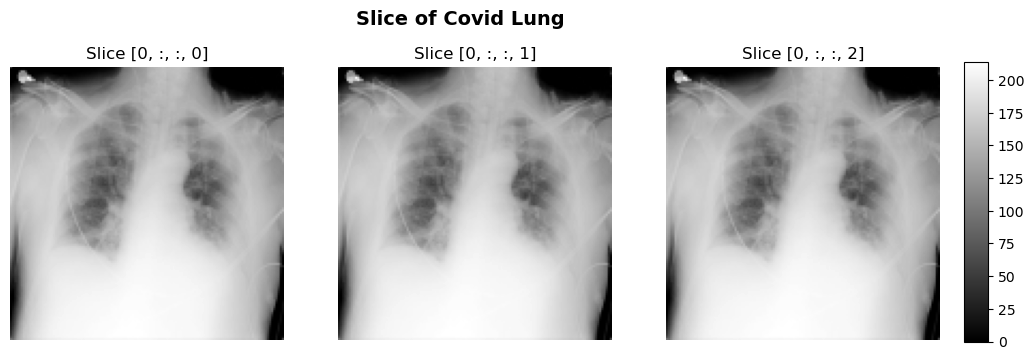

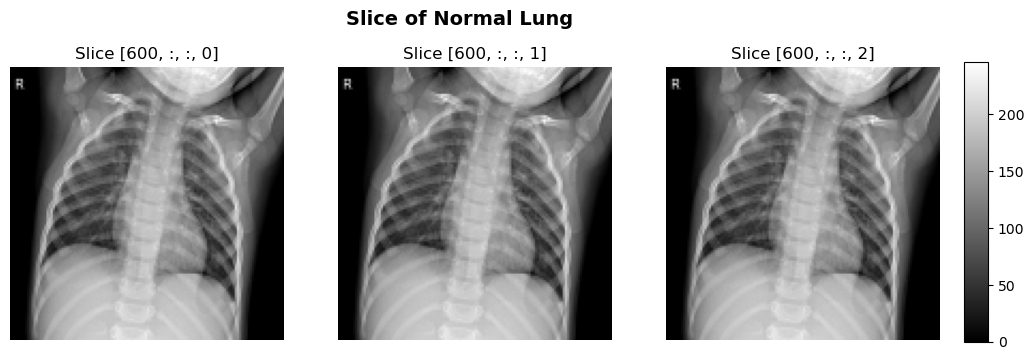

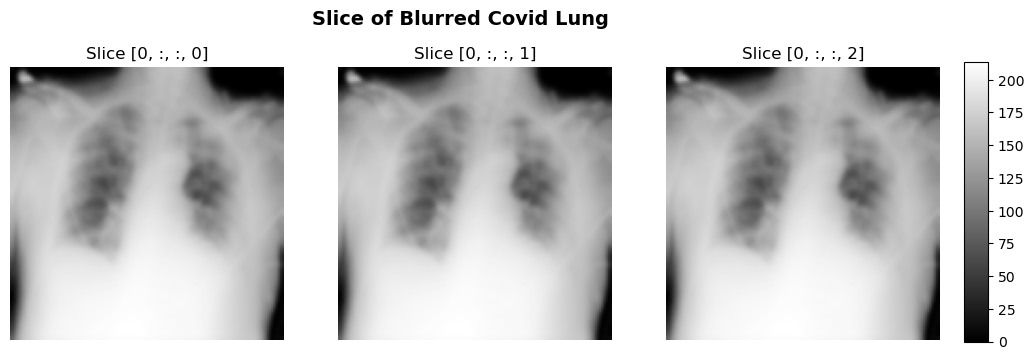

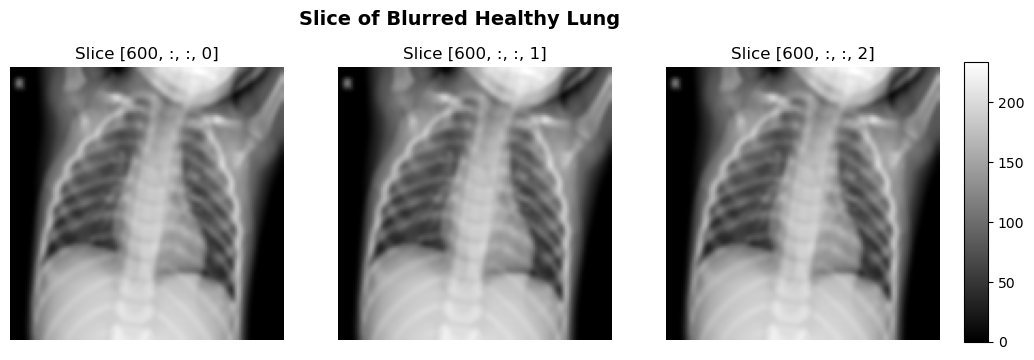

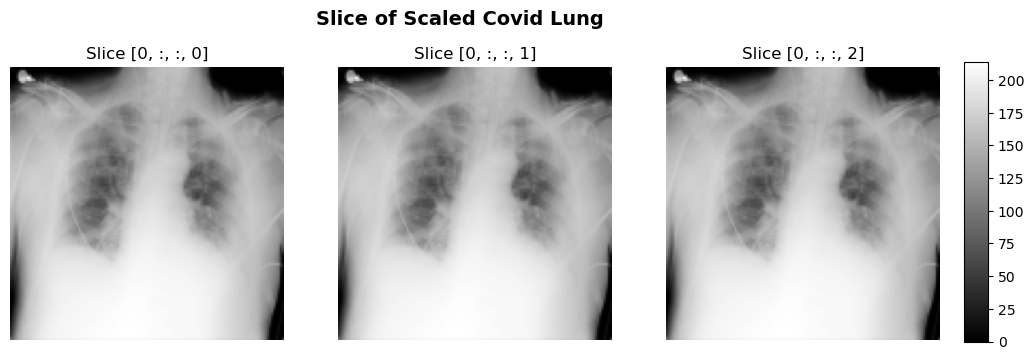

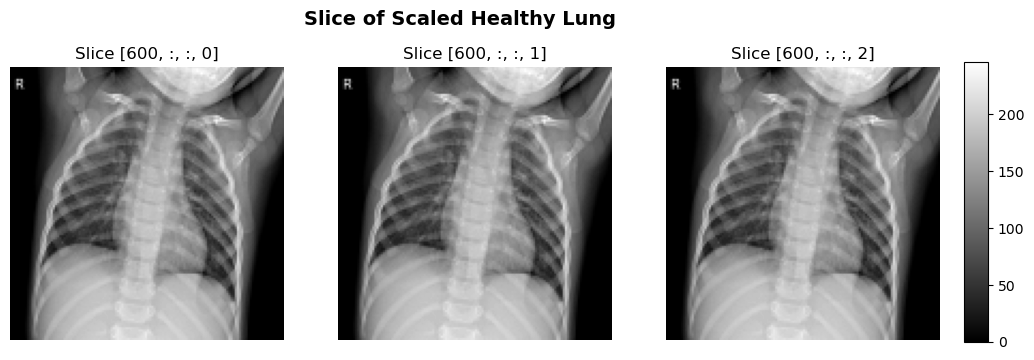

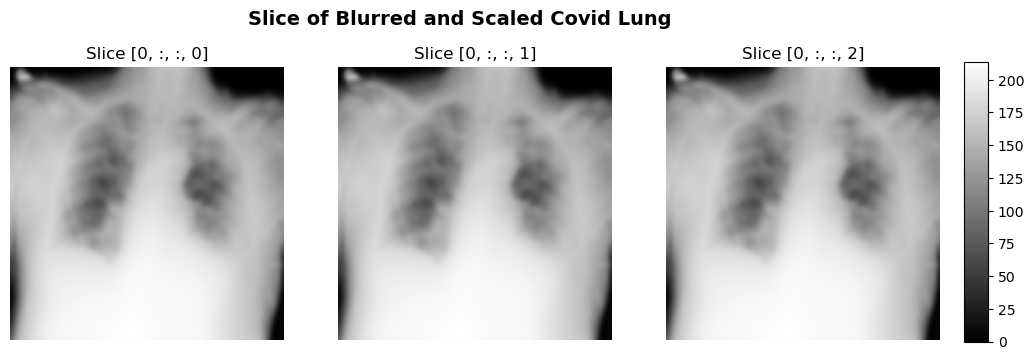

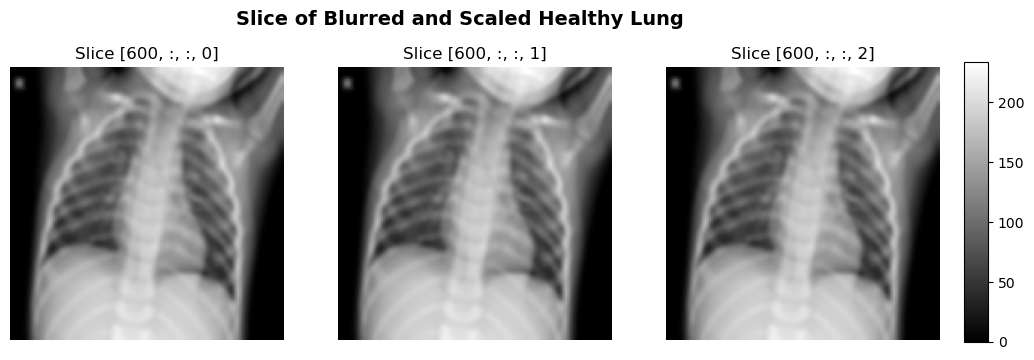

In [10]:
# Show unaltered lungs
print_image(X_train, COVID, "Slice of Covid Lung")
print_image(X_train, HEALTHY, "Slice of Normal Lung")

# Create training sets
y_train_cat = np.concatenate((y_train, np.copy(y_train)), axis=0)
X_train_dup = np.concatenate((X_train, np.copy(X_train)), axis=0)
X_train_blur = blur_data(X_train)
X_train_scale = scale_data(X_train)
X_train_blur_scale = blur_scale_data(X_train)

# Shuffle training sets
idx = np.arange(X_train_dup.shape[0])
np.random.shuffle(idx)

y_train_cat = y_train_cat[idx]
X_train_dup = X_train_dup[idx]
X_train_blur = X_train_blur[idx]
X_train_scale = X_train_scale[idx]
X_train_blur_scale = X_train_blur_scale[idx]


In [52]:
print(X_train_dup.shape)
print(X_val.shape)

(4000, 128, 128, 3)
(1500, 128, 128, 3)


### 2D Convolutional Neural Network Training

**Model** The 2D convolutional neural network model architecture is shown below. The model is trained to 100 epochs, and the epoch with the highest accuracy is saved and used for further analysis. Training and validation loss plots along with accuracy plots for each of the model training are shown below.

In [25]:
def modelArchitecture2D(X_train, model_type, y_t = y_train_cat):
    model = tf.keras.Sequential([

        tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
        
        tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint(f"/Users/allenchang/Downloads/CovidDataset/best{model_type}_model.keras", monitor='val_accuracy', save_best_only=True, mode='max')
    history = model.fit(X_train, y_t, epochs = 100, batch_size = 16, validation_data=(X_val, y_val), verbose=1, callbacks=[checkpoint])
    
    model.load_weights(f"/Users/allenchang/Downloads/CovidDataset/best{model_type}_model.keras")
    
    return history, model


In [26]:
def train_model(X_t, model_type, y_t = y_train_cat, X_val = X_val, y_val = y_val): # Trains model and plots the model progress
    
    history, model = modelArchitecture2D(X_t, model_type)
    
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(10, 6))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Validation Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'ro', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    
    plt.savefig(f'/Users/allenchang/Downloads/CovidDataset/{model_type}.png')
    plt.show()

    validation_loss, validation_accuracy = model.evaluate(X_val, y_val)
    print(f"Validation accuracy: {validation_accuracy:.4f}")
    
    return model, history
    

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.8790 - loss: 2.9034 - val_accuracy: 0.3853 - val_loss: 2.7854
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.9261 - loss: 1.3572 - val_accuracy: 0.4833 - val_loss: 1.8724
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9304 - loss: 0.8796 - val_accuracy: 0.5493 - val_loss: 1.4306
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.9329 - loss: 0.6614 - val_accuracy: 0.4607 - val_loss: 2.0477
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.9423 - loss: 0.5322 - val_accuracy: 0.6520 - val_loss: 1.1718
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9480 - loss: 0.4426 - val_accuracy: 0.6460 - val_loss: 0.9669
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9505 - loss: 0.4134 - val_accuracy: 0.6213 - val_loss: 1.0780
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9427 - loss: 0

250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.9651 - loss: 0.3064 - val_accuracy: 0.5693 - val_loss: 1.3602
Epoch 51/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.9620 - loss: 0.3084 - val_accuracy: 0.6647 - val_loss: 1.0750
Epoch 52/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.9606 - loss: 0.3014 - val_accuracy: 0.6633 - val_loss: 1.1749
Epoch 53/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9677 - loss: 0.2921 - val_accuracy: 0.6727 - val_loss: 1.1821
Epoch 54/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.9584 - loss: 0.2996 - val_accuracy: 0.6073 - val_loss: 1.3241
Epoch 55/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9571 - loss: 0.3095 - val_accuracy: 0.7967 - val_loss: 0.6926
Epoch 56/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9609 - loss: 0.2949 - val_accuracy: 0.7353 - val_loss: 0.8839
Epoch 57/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.9632 - loss: 0.3049

250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9580 - loss: 0.2828 - val_accuracy: 0.7587 - val_loss: 0.7582
Epoch 100/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.9604 - loss: 0.2731 - val_accuracy: 0.7347 - val_loss: 1.0232


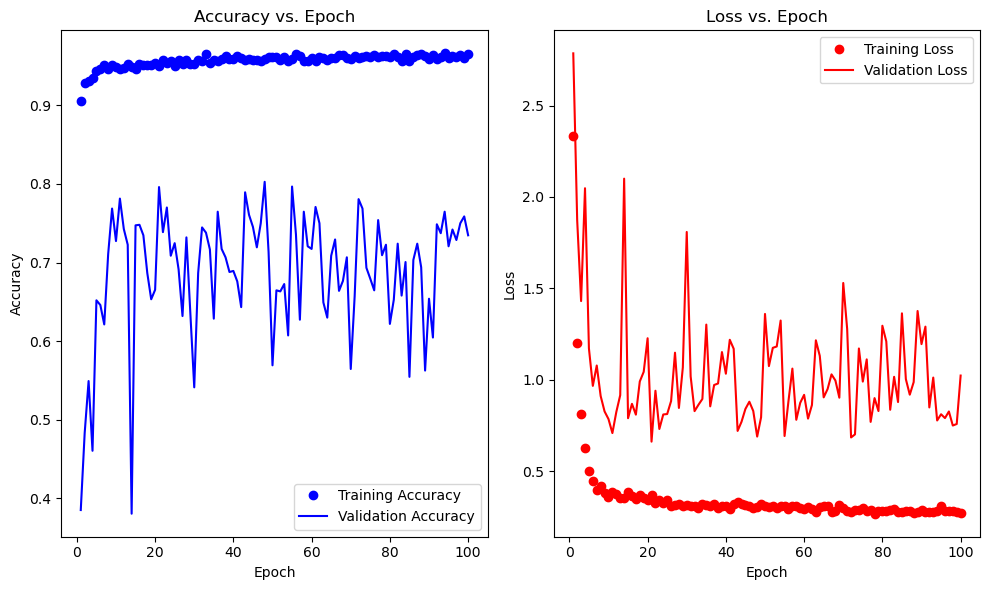

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8030 - loss: 0.6561
Validation accuracy: 0.8027


In [27]:
doubleModel, doubleHistory = train_model(X_train_dup, "Duplicated")

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.8373 - loss: 3.0771 - val_accuracy: 0.4200 - val_loss: 2.5939
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.9101 - loss: 1.5637 - val_accuracy: 0.4200 - val_loss: 2.4839
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.9182 - loss: 1.0314 - val_accuracy: 0.4453 - val_loss: 1.9609
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.9326 - loss: 0.7775 - val_accuracy: 0.5987 - val_loss: 1.2334
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.9302 - loss: 0.6093 - val_accuracy: 0.6860 - val_loss: 1.0341
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.9336 - loss: 0.5333 - val_accuracy: 0.6527 - val_loss: 1.0181
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.9479 - loss: 0.4579 - val_accuracy: 0.6293 - val_loss: 1.2432
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.9424 - loss: 0

250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9499 - loss: 0.3426 - val_accuracy: 0.7207 - val_loss: 0.8108
Epoch 51/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9408 - loss: 0.3403 - val_accuracy: 0.6893 - val_loss: 0.9125
Epoch 52/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.9564 - loss: 0.3131 - val_accuracy: 0.7213 - val_loss: 0.7785
Epoch 53/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.9546 - loss: 0.2921 - val_accuracy: 0.5573 - val_loss: 1.4897
Epoch 54/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.9561 - loss: 0.3252 - val_accuracy: 0.7380 - val_loss: 0.8779
Epoch 55/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.9561 - loss: 0.2982 - val_accuracy: 0.6760 - val_loss: 0.8738
Epoch 56/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.9513 - loss: 0.3015 - val_accuracy: 0.7480 - val_loss: 0.7976
Epoch 57/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.9534 - loss: 0.3098

250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9582 - loss: 0.2866 - val_accuracy: 0.7427 - val_loss: 0.7775
Epoch 100/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9521 - loss: 0.3025 - val_accuracy: 0.7040 - val_loss: 0.8677


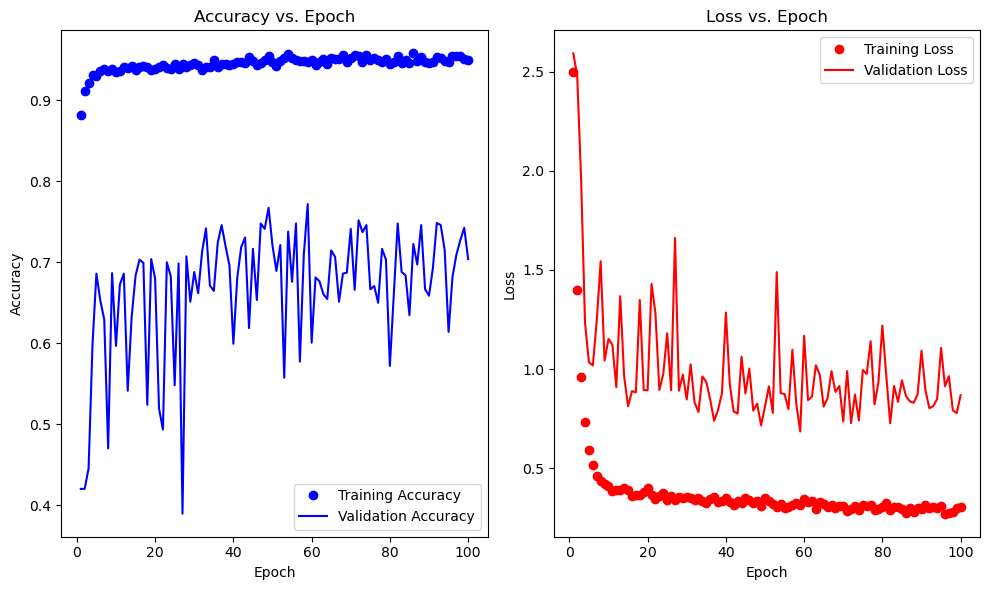

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6862 - loss: 0.8391
Validation accuracy: 0.7720


In [28]:
blurModel, blurHistory = train_model(X_train_blur, "Blurred")

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.8832 - loss: 2.9184 - val_accuracy: 0.4053 - val_loss: 2.7427
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.9286 - loss: 1.3871 - val_accuracy: 0.5153 - val_loss: 2.3818
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9436 - loss: 0.8763 - val_accuracy: 0.5793 - val_loss: 1.3863
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.9403 - loss: 0.6376 - val_accuracy: 0.4833 - val_loss: 1.7794
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9391 - loss: 0.5406 - val_accuracy: 0.5433 - val_loss: 1.3446
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9504 - loss: 0.4601 - val_accuracy: 0.7080 - val_loss: 0.9391
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9468 - loss: 0.4407 - val_accuracy: 0.7033 - val_loss: 0.8893
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9507 - loss: 0

250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9576 - loss: 0.3122 - val_accuracy: 0.6980 - val_loss: 1.0358
Epoch 51/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9640 - loss: 0.2947 - val_accuracy: 0.7287 - val_loss: 0.8122
Epoch 52/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9643 - loss: 0.2845 - val_accuracy: 0.7113 - val_loss: 0.8238
Epoch 53/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9658 - loss: 0.2837 - val_accuracy: 0.6500 - val_loss: 1.0532
Epoch 54/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9628 - loss: 0.2730 - val_accuracy: 0.6520 - val_loss: 1.0761
Epoch 55/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9592 - loss: 0.2956 - val_accuracy: 0.7247 - val_loss: 0.8217
Epoch 56/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9678 - loss: 0.2860 - val_accuracy: 0.6453 - val_loss: 1.0478
Epoch 57/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9700 - loss: 0.2849

250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9601 - loss: 0.3117 - val_accuracy: 0.7000 - val_loss: 0.8582
Epoch 100/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9658 - loss: 0.2830 - val_accuracy: 0.6013 - val_loss: 1.2176


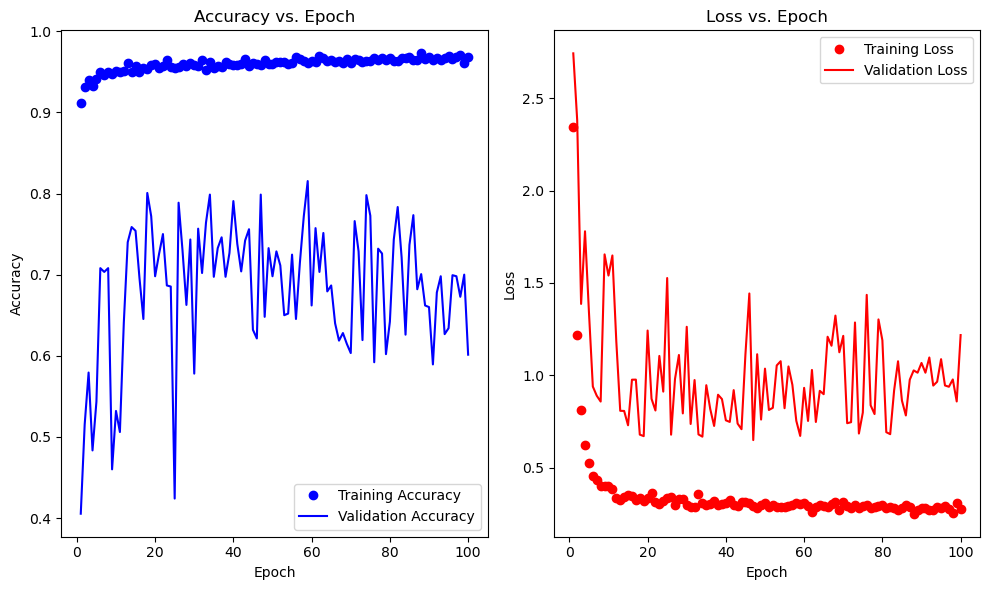

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8162 - loss: 0.6378
Validation accuracy: 0.8153


In [29]:
scaleModel, scaleHistory = train_model(X_train_scale, "Scaled")

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 87ms/step - accuracy: 0.8464 - loss: 2.9884 - val_accuracy: 0.4753 - val_loss: 2.4814
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.9087 - loss: 1.5541 - val_accuracy: 0.4100 - val_loss: 2.1874
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9259 - loss: 1.0073 - val_accuracy: 0.4367 - val_loss: 2.0643
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9202 - loss: 0.7646 - val_accuracy: 0.5927 - val_loss: 1.2667
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9315 - loss: 0.5995 - val_accuracy: 0.5353 - val_loss: 1.2472
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.9298 - loss: 0.5468 - val_accuracy: 0.5160 - val_loss: 1.4941
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.9371 - loss: 0.4575 - val_accuracy: 0.6120 - val_loss: 0.9906
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9287 - loss: 0

250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9404 - loss: 0.3472 - val_accuracy: 0.5193 - val_loss: 1.6930
Epoch 51/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9499 - loss: 0.3221 - val_accuracy: 0.7173 - val_loss: 0.8913
Epoch 52/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9548 - loss: 0.3128 - val_accuracy: 0.6260 - val_loss: 1.0252
Epoch 53/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9535 - loss: 0.3243 - val_accuracy: 0.6967 - val_loss: 0.8354
Epoch 54/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9492 - loss: 0.3385 - val_accuracy: 0.6927 - val_loss: 0.9036
Epoch 55/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9543 - loss: 0.3046 - val_accuracy: 0.6033 - val_loss: 1.2330
Epoch 56/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9528 - loss: 0.3273 - val_accuracy: 0.7327 - val_loss: 0.8884
Epoch 57/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9526 - loss: 0.3274

250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.9584 - loss: 0.2601 - val_accuracy: 0.7020 - val_loss: 0.9653
Epoch 100/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.9549 - loss: 0.2813 - val_accuracy: 0.5167 - val_loss: 1.5531


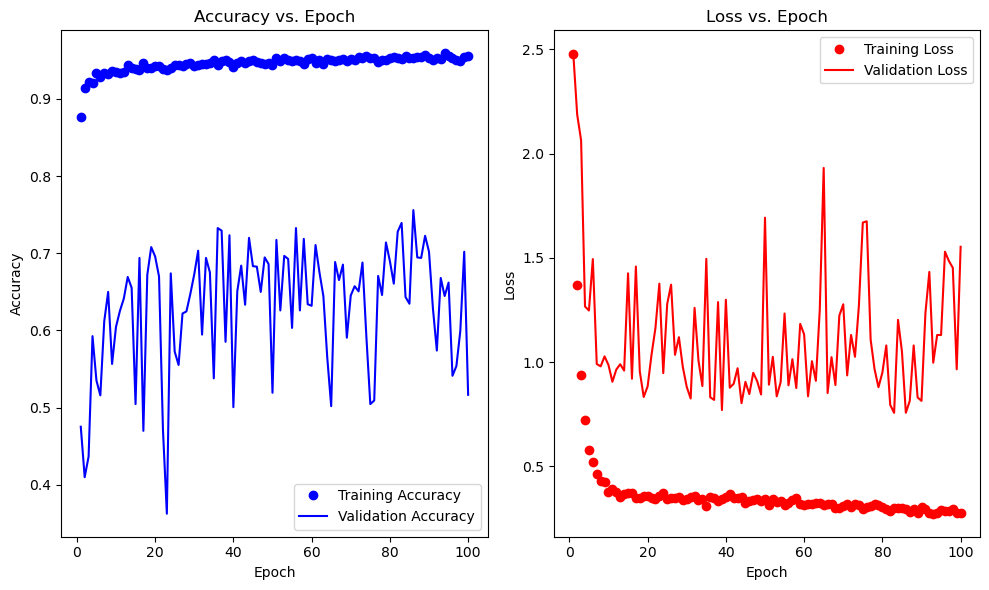

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7899 - loss: 0.6429
Validation accuracy: 0.7560


In [30]:
blurscaleModel, blurscaleHistory = train_model(X_train_blur_scale, "Blurred and Scaled")

### Comparative Model Analysis

**Comparing Augmentation Methods** The model trained on blurred and scaled data has the highest AUPRC, followed by the model trained on scaled data, the model trained on blurred data, and the control model. Additionally, the model trained on blurred data has the highest F1-score followed by the model trained on scaled data, the model trained on blurred and scaled data, and the control model. The same ranking is observed for accuracy. The model trained on blurred data has highest precision, followed by the model trained on scaled data, the control model, and the model trained on blurred and scaled data. Lastly, the model trained on blurred and scaled data has the highest recall, followed by the control model, the model trained on scaled data, and the model trained on blurred data.  

In [43]:
Xtest_C = load_images(testC)
Xtest_N = load_images(testN)
Xtest_C_avg = np.mean(Xtest_C, axis = 0)
Xtest_N_avg = np.mean(Xtest_N, axis = 0)

(500, 128, 128, 3)
(500, 128, 128, 3)


In [44]:
doubleModel = tf.keras.models.load_model("/Users/allenchang/Downloads/CovidDataset/bestDuplicated_model.keras")
blurModel = tf.keras.models.load_model("/Users/allenchang/Downloads/CovidDataset/bestBlurred_model.keras")
scaleModel = tf.keras.models.load_model("/Users/allenchang/Downloads/CovidDataset/bestScaled_model.keras")
blurscaleModel = tf.keras.models.load_model("/Users/allenchang/Downloads/CovidDataset/bestBlurred and Scaled_model.keras")

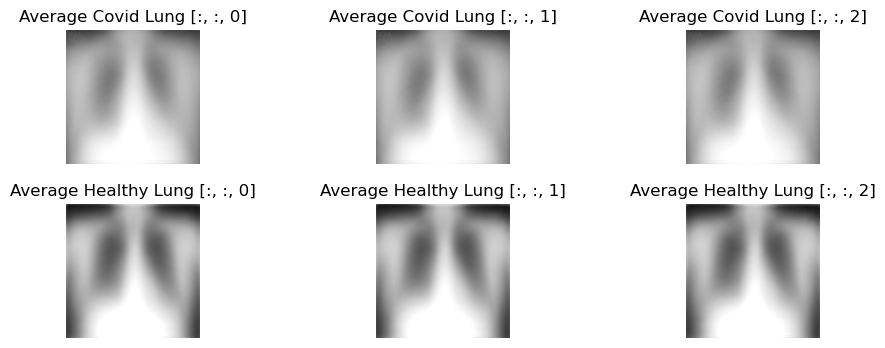

In [45]:
def plot_avg_testimage(Xtest_C_avg = Xtest_C_avg, Xtest_N_avg = Xtest_N_avg):
    fig, axs = plt.subplots(2, 3, figsize=(12, 4))
    cmp = 'gist_gray'
    vmax = 200
    vmin = 0

    axs[0, 0].imshow(Xtest_C_avg[:, :, 0], cmap=cmp, vmax=vmax, vmin=vmin)
    axs[0, 0].set_title(f"Average Covid Lung [:, :, 0]")
    axs[0, 0].axis("off")

    axs[0, 1].imshow(Xtest_C_avg[:, :, 1], cmap=cmp, vmax=vmax, vmin=vmin)
    axs[0, 1].set_title(f"Average Covid Lung [:, :, 1]")
    axs[0, 1].axis("off")

    axs[0, 2].imshow(Xtest_C_avg[:, :, 2], cmap=cmp, vmax=vmax, vmin=vmin)
    axs[0, 2].set_title(f"Average Covid Lung [:, :, 2]")
    axs[0, 2].axis("off")

    # Second row: Xtrain_N_avg
    axs[1, 0].imshow(Xtest_N_avg[:, :, 0], cmap=cmp, vmax=vmax, vmin=vmin)
    axs[1, 0].set_title(f"Average Healthy Lung [:, :, 0]")
    axs[1, 0].axis("off")

    axs[1, 1].imshow(Xtest_N_avg[:, :, 1], cmap=cmp, vmax=vmax, vmin=vmin)
    axs[1, 1].set_title(f"Average Healthy Lung [:, :, 1]")
    axs[1, 1].axis("off")

    axs[1, 2].imshow(Xtest_N_avg[:, :, 2], cmap=cmp, vmax=vmax, vmin=vmin)
    axs[1, 2].set_title(f"Average Healthy Lung [:, :, 2]")
    axs[1, 2].axis("off")
#     

    plt.subplots_adjust(wspace=0, hspace=0.3)
    
#     plt.savefig(f'/Users/allenchang/Downloads/CovidDataset/average.png')
    
    plt.show()

plot_avg_testimage()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


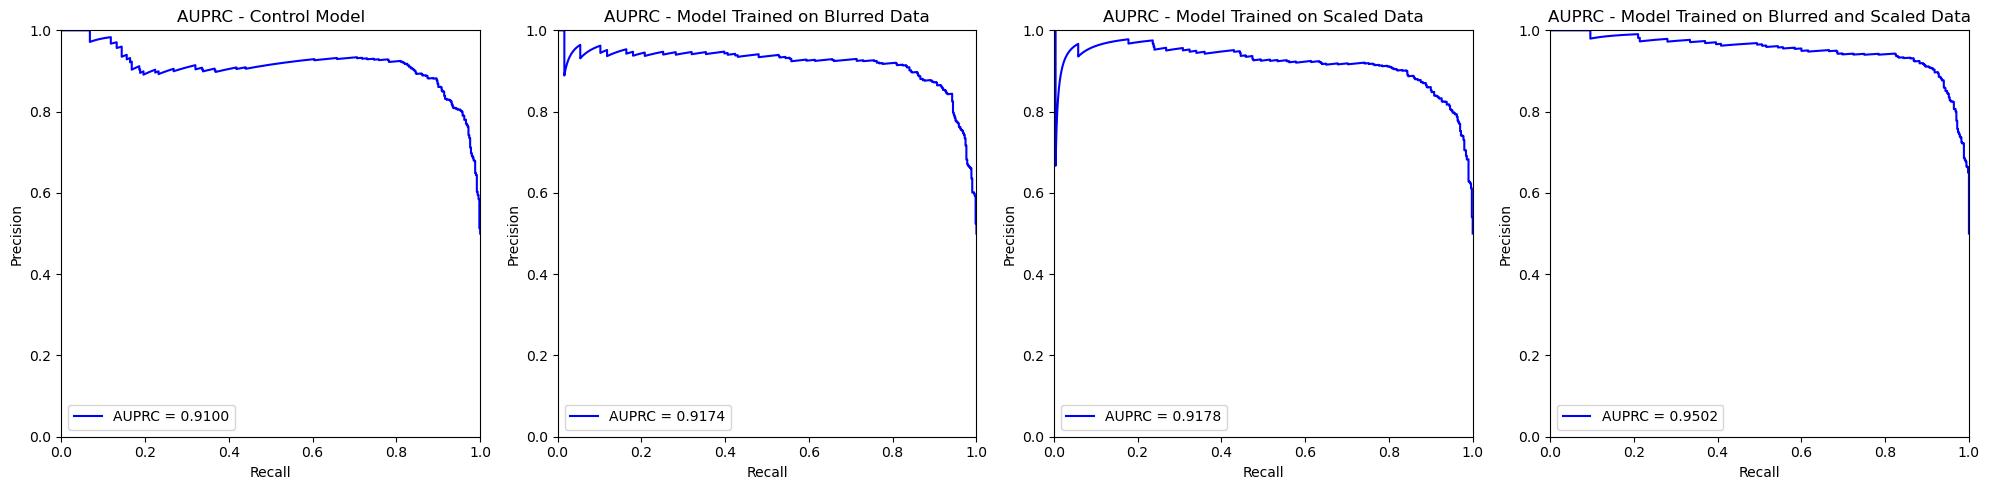

In [46]:
def plot_auprc(X_test, y_test, doubleModel, blurModel, scaleModel, blurscaleModel):
    # Predictions for each model
    doublepred = doubleModel.predict(X_test)
    blurpred = blurModel.predict(X_test)
    scalepred = scaleModel.predict(X_test)
    blurscalepred = blurscaleModel.predict(X_test)
    
    # Calculate AUPRC for each model
    precision_double, recall_double, _ = precision_recall_curve(y_test, doublepred)
    auprc_double = auc(recall_double, precision_double)
    
    precision_blur, recall_blur, _ = precision_recall_curve(y_test, blurpred)
    auprc_blur = auc(recall_blur, precision_blur)
    
    precision_scale, recall_scale, _ = precision_recall_curve(y_test, scalepred)
    auprc_scale = auc(recall_scale, precision_scale)
    
    precision_blurscale, recall_blurscale, _ = precision_recall_curve(y_test, blurscalepred)
    auprc_blurscale = auc(recall_blurscale, precision_blurscale)
    
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    
    # Plot AUPRC for doubleModel
    axs[0].plot(recall_double, precision_double, 'b', label=f'AUPRC = {auprc_double:.4f}')
    axs[0].set_title('AUPRC - Control Model')
    axs[0].set_xlim([0, 1])
    axs[0].set_ylim([0, 1])
    axs[0].set_ylabel('Precision')
    axs[0].set_xlabel('Recall')
    
    # Plot AUPRC for blurModel
    axs[1].plot(recall_blur, precision_blur, 'b', label=f'AUPRC = {auprc_blur:.4f}')
    axs[1].set_title('AUPRC - Model Trained on Blurred Data')
    axs[1].set_xlim([0, 1])
    axs[1].set_ylim([0, 1])
    axs[1].set_ylabel('Precision')
    axs[1].set_xlabel('Recall')
    
    # Plot AUPRC for scaleModel
    axs[2].plot(recall_scale, precision_scale, 'b', label=f'AUPRC = {auprc_scale:.4f}')
    axs[2].set_title('AUPRC - Model Trained on Scaled Data')
    axs[2].set_xlim([0, 1])
    axs[2].set_ylim([0, 1])
    axs[2].set_ylabel('Precision')
    axs[2].set_xlabel('Recall')
    
    
    # Plot AUPRC for blurscaleModel
    axs[3].plot(recall_blurscale, precision_blurscale, 'b', label=f'AUPRC = {auprc_blurscale:.4f}')
    axs[3].set_title('AUPRC - Model Trained on Blurred and Scaled Data')
    axs[3].set_xlim([0, 1])
    axs[3].set_ylim([0, 1])
    axs[3].set_ylabel('Precision')
    axs[3].set_xlabel('Recall')
    for ax in axs:
        ax.legend(loc='lower left')
    
    plt.tight_layout()
    
    plt.savefig(f'/Users/allenchang/Downloads/CovidDataset/AUPRC.png')
    plt.show()
    
    return doublepred, blurpred, scalepred, blurscalepred

doublepred, blurpred, scalepred, blurscalepred = plot_auprc(X_test, y_test, doubleModel, blurModel, scaleModel, blurscaleModel)


In [51]:
def prediction_metrics(doublepred = doublepred, blurpred = blurpred, scalepred = scalepred, blurscalepred = blurscalepred, y_test = y_test):
    # Round predictions to 0 or 1 for discrete analysis
    doublepred = np.round(doublepred).astype(int)
    blurpred = np.round(blurpred).astype(int)
    scalepred = np.round(scalepred).astype(int)
    blurscalepred = np.round(blurscalepred).astype(int)

    print(f"The f1-score for the Control Model is {f1_score(y_test, doublepred)}")
    print(f"The f1-score for the Model trained on Blurred data is {f1_score(y_test, blurpred)}")
    print(f"The f1-score for the Model trained on Scaled data is {f1_score(y_test, scalepred)}")
    print(f"The f1-score for the Model trained on Blurred and Scaled data is {f1_score(y_test, blurscalepred)}")
    print()
    print(f"The precision for the Control Model is {precision_score(y_test, doublepred)}")
    print(f"The precision for the Model trained on Blurred data is {precision_score(y_test, blurpred)}")
    print(f"The precision for the Model trained on Scaled data is {precision_score(y_test, scalepred)}")
    print(f"The precision for the Model trained on Blurred and Scaled data is {precision_score(y_test, blurscalepred)}")
    print()
    print(f"The recall for the Control Model is {recall_score(y_test, doublepred)}")
    print(f"The recall for the Model trained on Blurred data is {recall_score(y_test, blurpred)}")
    print(f"The recall for the Model trained on Scaled data is {recall_score(y_test, scalepred)}")
    print(f"The recall for the Model trained on Blurred and Scaled data is {recall_score(y_test, blurscalepred)}")
    print()
    print(f"The accuracy the Control Model is {accuracy_score(y_test, doublepred)}")
    print(f"The accuracy for the Model trained on Blurred data is {accuracy_score(y_test, blurpred)}")
    print(f"The accuracy for the Model trained on Scaled data is {accuracy_score(y_test, scalepred)}")
    print(f"The accuracy for the Model trained on Blurred and Scaled data is {accuracy_score(y_test, blurscalepred)}")


prediction_metrics()

The f1-score for the Control Model is 0.8688372093023257
The f1-score for the Model trained on Blurred data is 0.8838133068520359
The f1-score for the Model trained on Scaled data is 0.8735849056603773
The f1-score for the Model trained on Blurred and Scaled data is 0.8715184186882301

The precision for the Control Model is 0.8121739130434783
The precision for the Model trained on Blurred data is 0.8777120315581854
The precision for the Model trained on Scaled data is 0.8267857142857142
The precision for the Model trained on Blurred and Scaled data is 0.7911908646003263

The recall for the Control Model is 0.934
The recall for the Model trained on Blurred data is 0.89
The recall for the Model trained on Scaled data is 0.926
The recall for the Model trained on Blurred and Scaled data is 0.97

The accuracy the Control Model is 0.859
The accuracy for the Model trained on Blurred data is 0.883
The accuracy for the Model trained on Scaled data is 0.866
The accuracy for the Model trained on 

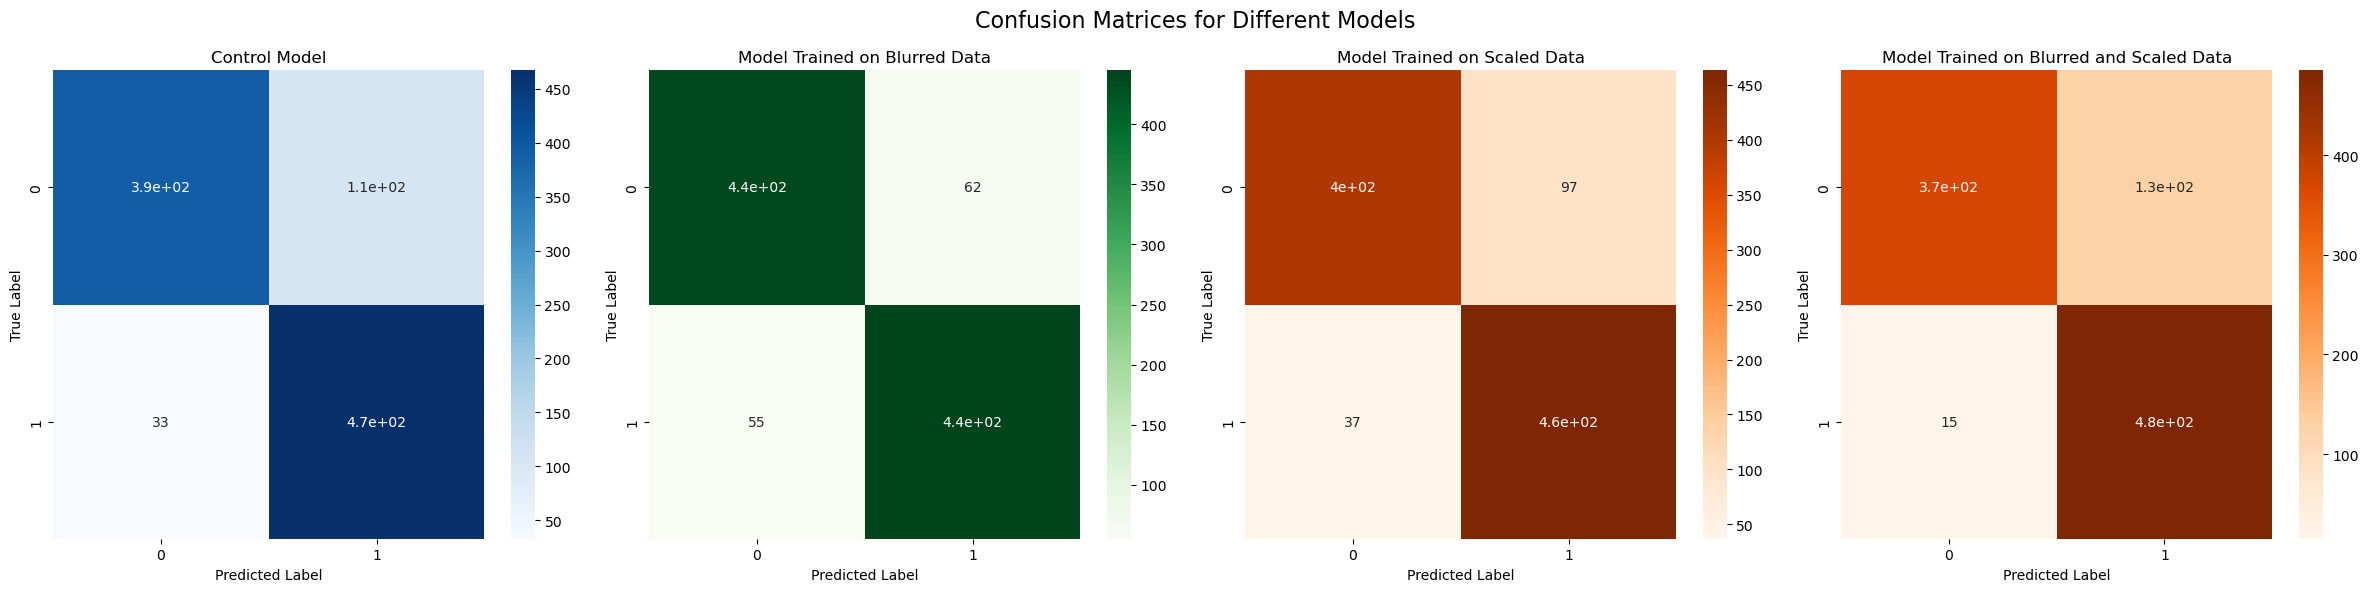

In [52]:
doublepred = np.round(doublepred).astype(int)
blurpred = np.round(blurpred).astype(int)
scalepred = np.round(scalepred).astype(int)
blurscalepred = np.round(blurscalepred).astype(int)


fig, axes = plt.subplots(1, 4, figsize=(24, 6))
fig.suptitle("Confusion Matrices for Different Models", fontsize=16)

# Control Model Confusion Matrix
double_matrix = confusion_matrix(y_test, doublepred)
sns.heatmap(double_matrix, annot=True, cmap='Blues', ax=axes[0])
axes[0].set_title("Control Model")
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')


# Blurred Model Confusion Matrix
blurred_matrix = confusion_matrix(y_test, blurpred)
sns.heatmap(blurred_matrix, annot=True, cmap='Greens', ax=axes[1])
axes[1].set_title("Model Trained on Blurred Data")
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

# Scaled Model Confusion Matrix
scaled_matrix = confusion_matrix(y_test, scalepred)
sns.heatmap(scaled_matrix, annot=True, cmap='Oranges', ax=axes[2])
axes[2].set_title("Model Trained on Scaled Data")
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')

# Blurred Scaled Model Confusion Matrix
blurredscaled_matrix = confusion_matrix(y_test, blurscalepred)
sns.heatmap(blurredscaled_matrix, annot=True, cmap='Oranges', ax=axes[3])
axes[3].set_title("Model Trained on Blurred and Scaled Data")
axes[3].set_xlabel('Predicted Label')
axes[3].set_ylabel('True Label')



plt.tight_layout()

plt.savefig(f'/Users/allenchang/Downloads/CovidDataset/confusion.png')
plt.show()

## Concluding Remarks

To accomodate time and memory requirements, datasets were trimmed down and scaled from the original dataset according to the parameters above. Models were also only ran to 100 epochs. However, this seems sufficient, since overfitting can be observed as validation loss increases. Nevertheless, more tests can be performed in the future to determine whether the following augmentation methods truly present a statistically significant difference in performance. Furthermore, as mentioned before, more experimentation with different architectures or hyperparameters may result in better model performance. Model weights are available upon request. 